In [18]:
import gc
import gzip
import pandas as pd
import os
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression

try:
    from scipy.stats import norm
except ImportError:
    norm = None

In [2]:
file_path = r"CSV/Exports/Temp/11_keep_24h/merged_df.csv"
stroke_df = pd.read_csv(file_path)
stroke_df_tz8 = stroke_df[stroke_df["Time_Zone"] == 8].copy()

# Time to event

In [3]:
"""
Για την ομοιομορφία κρατάω τις εγγραφές των ασθενών που έχουν παραμονή περισσότερο τις μιας μέρας

Δεν θα είναι σωστό να συγκρίνω τις τιμές 24 ώρου για κάποιον που έχει καθίσει λιγότερες ώρες.
"""

stroke_df_tz8_los = stroke_df_tz8[stroke_df_tz8["los"] >= 1].copy()

# Duration στα events 30, 180, 360

In [4]:
df = stroke_df_tz8_los.copy()  # 1 row/stay, Time_Zone=8, LOS>=24h, sofa μέσα

# 1) Datetimes
df["icu_intime"] = pd.to_datetime(df["icu_intime"], errors="coerce")
df["dod"]        = pd.to_datetime(df["dod"], errors="coerce")

# 2) Time to death (days)
df["time_to_death_days"] = (df["dod"] - df["icu_intime"]).dt.total_seconds() / 86400.0

# Aν βρεθούν αρνητικά durations τα κάνω μηδέν
neg = df["time_to_death_days"].notna() & (df["time_to_death_days"] < 0)
if neg.any():
    print(f"Βρέθηκαν {neg.sum()} αρνητικά time_to_death_days. Θα τα κάνω 0.")
    df.loc[neg, "time_to_death_days"] = 0.0

# 3) duration + event για κάθε horizon
for H in [30, 180, 360]:
    mort_col = f"mort_{H}d"

    # event: από τα labels που έχω ήδη
    df[f"event_{H}d"] = pd.to_numeric(df[mort_col], errors="coerce").fillna(0).astype(int)

    # duration: αν υπάρχει dod -> min(ttd, H), αλλιώς censor στο H
    ttd = df["time_to_death_days"]
    df[f"duration_{H}d"] = np.where(
        ttd.notna(),
        np.minimum(ttd, float(H)),
        float(H)
    ).astype(float)

    # clamp για ασφάλεια
    df[f"duration_{H}d"] = df[f"duration_{H}d"].clip(lower=0, upper=float(H))

# 4) Quick summary
print("N:", len(df))
print("Deaths within 30d :", df["event_30d"].sum())
print("Deaths within 180d:", df["event_180d"].sum())
print("Deaths within 360d:", df["event_360d"].sum())

df[["time_to_death_days",
    "event_30d","duration_30d",
    "event_180d","duration_180d",
    "event_360d","duration_360d"
]].head(10)


Βρέθηκαν 6 αρνητικά time_to_death_days. Θα τα κάνω 0.
N: 3059
Deaths within 30d : 688
Deaths within 180d: 931
Deaths within 360d: 1041


,time_to_death_days,event_30d,duration_30d,event_180d,duration_180d,event_360d,duration_360d
7,NaN,0,30.000000,0,180.000000,0,360.000000
47,NaN,0,30.000000,0,180.000000,0,360.000000
55,NaN,0,30.000000,0,180.000000,0,360.000000
63,7.720833,1,7.720833,1,7.720833,1,7.720833
79,NaN,0,30.000000,0,180.000000,0,360.000000
87,NaN,0,30.000000,0,180.000000,0,360.000000
119,26.153877,1,26.153877,1,26.153877,1,26.153877
143,27.146238,1,27.146238,1,27.146238,1,27.146238
151,NaN,0,30.000000,0,180.000000,0,360.000000
159,10.903160,1,10.903160,1,10.903160,1,10.903160


In [5]:
def sanity_check_labels(df, H):
    mort_col = f"mort_{H}d"
    event_from_dod = ((df["time_to_death_days"].notna()) & (df["time_to_death_days"] <= H)).astype(int)
    mismatch = (df[mort_col].astype(int) != event_from_dod).sum()
    print(f"H={H}d mismatch mort_{H}d vs (dod<=H from icu_intime): {mismatch} / {len(df)}")
    if mismatch > 0:
        display(df.loc[df[mort_col].astype(int) != event_from_dod,
                       ["subject_id","hadm_id","stay_id","icu_intime","dod","time_to_death_days",mort_col]].head(10))

for H in [30,180,360]:
    sanity_check_labels(df, H)

H=30d mismatch mort_30d vs (dod<=H from icu_intime): 0 / 3059
H=180d mismatch mort_180d vs (dod<=H from icu_intime): 0 / 3059
H=360d mismatch mort_360d vs (dod<=H from icu_intime): 0 / 3059


# RDW

In [6]:
df = df.copy()

rdw_col = "RDW - Median"   # άλλαξέ το αν θες Mean
df["RDW_value"] = df[rdw_col]

# Quartiles (Q1–Q4)
df["RDW_q"] = pd.qcut(df["RDW_value"], 4, labels=["Q1","Q2","Q3","Q4"])

# quick check
print(df["RDW_q"].value_counts(dropna=False))
print("RDW missing:", df["RDW_value"].isna().mean())

RDW_q
Q1     802
Q2     756
Q3     739
Q4     733
NaN     29
Name: count, dtype: int64
RDW missing: 0.009480222294867604


# Kaplan–Meier curves

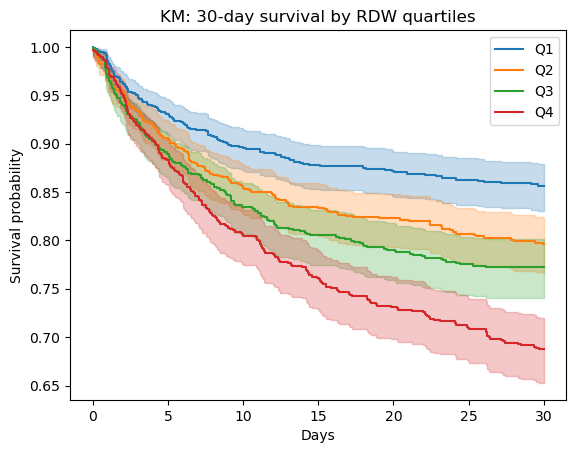

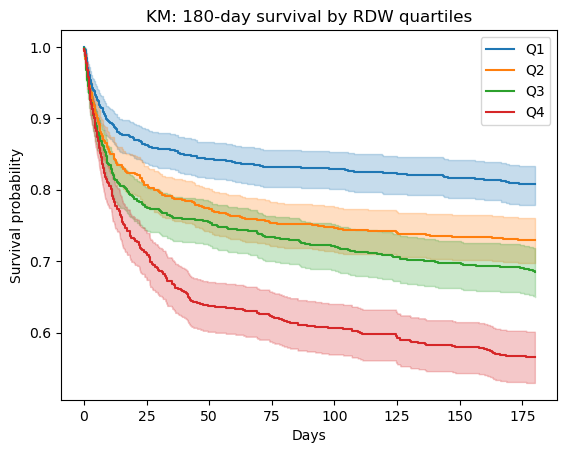

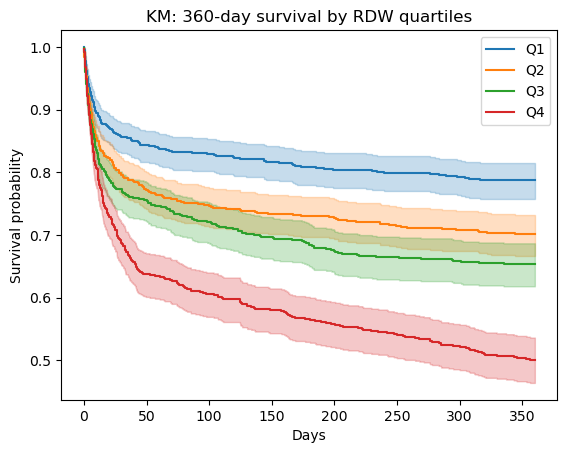

In [7]:
def km_by_quartile(df, H, group_col="RDW_q"):
    kmf = KaplanMeierFitter()
    ax = None

    duration_col = f"duration_{H}d"
    event_col    = f"event_{H}d"

    for q in ["Q1","Q2","Q3","Q4"]:
        mask = df[group_col] == q
        dfg = df.loc[mask, [duration_col, event_col]].dropna()
        kmf.fit(durations=dfg[duration_col], event_observed=dfg[event_col], label=q)
        ax = kmf.plot(ax=ax)

    ax.set_title(f"KM: {H}-day survival by RDW quartiles")
    ax.set_xlabel("Days")
    ax.set_ylabel("Survival probability")
    plt.show()

for H in [30, 180, 360]:
    km_by_quartile(df, H)


# Cox regression

In [8]:
import pandas as pd
from lifelines import CoxPHFitter

# gender -> numeric
df["gender_M"] = (df["gender"] == "M").astype(int)

# dummies
race_dummies  = pd.get_dummies(df["race"], prefix="race", drop_first=True)
rdw_q_dummies = pd.get_dummies(df["RDW_q"], prefix="RDWq", drop_first=True)  # Q1 reference

# Build one modeling table that contains all durations/events
base_cols = [
    "age", "gender_M",
    "sofa",
    "GCS - Median",
    "Non Invasive Blood Pressure mean (mmHg) - Median"
]

model_df = pd.concat(
    [
        df[[f"duration_{H}d" for H in [30,180,360]] + [f"event_{H}d" for H in [30,180,360]] + base_cols],
        race_dummies,
        rdw_q_dummies
    ],
    axis=1
)

rdw_q_cols = [c for c in model_df.columns if c.startswith("RDWq_")]
race_cols  = [c for c in model_df.columns if c.startswith("race_")]

model1_covs = ["age", "gender_M"] + race_cols + rdw_q_cols
model2_covs = model1_covs + ["sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

def fit_cox(model_df, H, covariates):
    duration_col = f"duration_{H}d"
    event_col    = f"event_{H}d"
    d = model_df[[duration_col, event_col] + covariates].dropna().copy()

    cph = CoxPHFitter()
    cph.fit(d, duration_col=duration_col, event_col=event_col)
    return cph, d

for H in [30, 180, 360]:
    print("\n" + "="*60)
    print(f"COX — Horizon: {H} days")

    cph1, d1 = fit_cox(model_df, H, model1_covs)
    print(f"Model 1 N used: {len(d1)} | events: {d1[f'event_{H}d'].sum()}")
    cph1.print_summary()

    cph2, d2 = fit_cox(model_df, H, model2_covs)
    print(f"\nModel 2 N used: {len(d2)} | events: {d2[f'event_{H}d'].sum()}")
    cph2.print_summary()



COX — Horizon: 30 days


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_30d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hig

Model 1 N used: 3059 | events: 688


<lifelines.CoxPHFitter: fitted with 3059 total observations, 2371 right-censored observations>
             duration col = 'duration_30d'
                event col = 'event_30d'
      baseline estimation = breslow
   number of observations = 3059
number of events observed = 688
   partial log-likelihood = -5322.40
         time fit was run = 2026-01-10 22:05:53 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
age                                             0.02      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                       -0.03      0.97      0.08           -0.19            0.12                0.83                1.12
race_ASIAN                                     15.66  6.31e+06   1109.04        -2158.03         2189.35                0.00                 inf
race_ASIAN - ASIAN INDIAN                       0.25      1.29   2125.46        -4165.58         4166.09                0.00                 inf
race_ASIAN - CHINESE                           15.40  4.88e+06   1109.04        -2158.29         2189.09                0.00                 inf
race_ASIAN - KOREAN                            15.59  5.87e+06   1109.05        -2158.10         2189.27                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                  16.06  9.39e+06   1109.04        -2157.63         2189.74                0.00                 inf
race_BLACK/AFRICAN                             15.57  5.75e+06   1109.05        -2158.12         2189.25                0.00                 inf
race_BLACK/AFRICAN AMERICAN                    15.03  3.36e+06   1109.04        -2158.66         2188.72                0.00                 inf
race_BLACK/CAPE VERDEAN                        14.78  2.62e+06   1109.05        -2158.91         2188.47                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                    14.64  2.28e+06   1109.05        -2159.05         2188.33                0.00                 inf
race_HISPANIC OR LATINO                        15.57  5.80e+06   1109.04        -2158.11         2189.26                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN        -0.02      0.98   3800.56        -7448.98         7448.94                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                0.09      1.09   2034.10        -3986.67         3986.85                0.00                 inf
race_HISPANIC/LATINO - CUBAN                   15.30  4.40e+06   1109.05        -2158.39         2188.99                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN               14.42  1.83e+06   1109.05        -2159.27         2188.11                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN              15.91  8.16e+06   1109.05        -2157.77         2189.60                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                -0.15      0.86   3800.56        -7449.10         7448.81                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                  0.96      2.61   3800.56        -7448.00         7449.92                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN            15.29  4.35e+06   1109.04        -2158.40         2188.97                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN               0.71      2.03   2202.55        -4316.21         4317.63                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                    0.19      1.21   2719.27        -5329.48         5329.86                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 15.25  4.18e+06   1109.05        -2158.44         2188.94                0.00                 inf
ra


Model 2 N used: 3025 | events: 670


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_30d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hig

<lifelines.CoxPHFitter: fitted with 3025 total observations, 2355 right-censored observations>
             duration col = 'duration_30d'
                event col = 'event_30d'
      baseline estimation = breslow
   number of observations = 3025
number of events observed = 670
   partial log-likelihood = -5021.17
         time fit was run = 2026-01-10 22:05:55 UTC

---
                                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                         
age                                               0.03      1.03      0.00            0.02            0.03                1.02                1.04
gender_M                                         -0.18      0.83      0.08           -0.34           -0.02                0.71                0.98
race_ASIAN                                       15.21  4.03e+06   1205.50        -2347.52         2377.94                0.00                 inf
race_ASIAN - ASIAN INDIAN                         0.14      1.15   2135.33        -4185.04         4185.31                0.00                 inf
race_ASIAN - CHINESE                             15.02  3.34e+06   1205.50        -2347.71         2377.75                0.00                 inf
race_ASIAN - KOREAN                              15.92  8.23e+06   1205.50        -2346.81         2378.65                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                    15.85  7.67e+06   1205.50        -2346.88         2378.58                0.00                 inf
race_BLACK/AFRICAN                               15.54  5.60e+06   1205.50        -2347.19         2378.27                0.00                 inf
race_BLACK/AFRICAN AMERICAN                      14.71  2.44e+06   1205.50        -2348.02         2377.44                0.00                 inf
race_BLACK/CAPE VERDEAN                          14.40  1.79e+06   1205.50        -2348.33         2377.13                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                      14.23  1.52e+06   1205.50        -2348.50         2376.96                0.00                 inf
race_HISPANIC OR LATINO                          15.01  3.30e+06   1205.50        -2347.72         2377.74                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN          -1.61      0.20   4138.98        -8113.87         8110.65                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                 -0.39      0.68   1815.32        -3558.36         3557.58                0.00                 inf
race_HISPANIC/LATINO - CUBAN                     15.10  3.62e+06   1205.50        -2347.63         2377.83                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN                 14.20  1.46e+06   1205.50        -2348.53         2376.93                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN                16.12  1.01e+07   1205.50        -2346.61         2378.85                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                  -0.10      0.91   4138.98        -8112.36         8112.16                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                    1.51      4.54   4138.98        -8110.75         8113.77                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN              14.93  3.04e+06   1205.50        -2347.80         2377.65                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN                 1.00      2.71   2334.03        -4573.61         4575.61                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                     -1.00      0.37   2994.05        -5869.24         5867.24                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   15.26  4.25e+06   1205.50        -2347.47         


COX — Horizon: 180 days
Model 1 N used: 3059 | events: 931


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_180d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3059 total observations, 2128 right-censored observations>
             duration col = 'duration_180d'
                event col = 'event_180d'
      baseline estimation = breslow
   number of observations = 3059
number of events observed = 931
   partial log-likelihood = -7168.75
         time fit was run = 2026-01-10 22:05:57 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
age                                             0.03      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                        0.04      1.04      0.07           -0.09            0.17                0.91                1.18
race_ASIAN                                     15.24  4.14e+06    806.62        -1565.71         1596.18                0.00                 inf
race_ASIAN - ASIAN INDIAN                       0.28      1.32   1554.81        -3047.09         3047.65                0.00                 inf
race_ASIAN - CHINESE                           15.15  3.79e+06    806.62        -1565.80         1596.09                0.00                 inf
race_ASIAN - KOREAN                            14.92  3.01e+06    806.62        -1566.03         1595.86                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                  15.43  5.04e+06    806.62        -1565.51         1596.38                0.00                 inf
race_BLACK/AFRICAN                             14.97  3.16e+06    806.62        -1565.98         1595.91                0.00                 inf
race_BLACK/AFRICAN AMERICAN                    14.70  2.43e+06    806.62        -1566.24         1595.65                0.00                 inf
race_BLACK/CAPE VERDEAN                        14.19  1.45e+06    806.62        -1566.76         1595.14                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                    14.44  1.87e+06    806.62        -1566.51         1595.39                0.00                 inf
race_HISPANIC OR LATINO                        14.95  3.12e+06    806.62        -1565.99         1595.90                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN        -0.15      0.86   2788.93        -5466.36         5466.06                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                0.07      1.08   1494.21        -2928.53         2928.68                0.00                 inf
race_HISPANIC/LATINO - CUBAN                   14.71  2.45e+06    806.62        -1566.24         1595.66                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN               14.07  1.29e+06    806.62        -1566.88         1595.02                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN              15.33  4.56e+06    806.62        -1565.62         1596.28                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                -0.22      0.80   2788.93        -5466.43         5465.99                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                  1.06      2.90   2788.93        -5465.15         5467.27                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN            14.98  3.20e+06    806.62        -1565.97         1595.93                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN               0.75      2.12   1620.92        -3176.20         3177.70                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                   15.29  4.37e+06    806.62        -1565.66         1596.24                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 14.57  2.14e+06    806.62        -1566.37         1595.52                0.00                 inf



Model 2 N used: 3025 | events: 913


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_180d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3025 total observations, 2112 right-censored observations>
             duration col = 'duration_180d'
                event col = 'event_180d'
      baseline estimation = breslow
   number of observations = 3025
number of events observed = 913
   partial log-likelihood = -6876.80
         time fit was run = 2026-01-10 22:05:59 UTC

---
                                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                         
age                                               0.03      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                         -0.09      0.92      0.07           -0.22            0.05                0.80                1.05
race_ASIAN                                       15.85  7.68e+06   1358.97        -2647.68         2679.39                0.00                 inf
race_ASIAN - ASIAN INDIAN                         0.25      1.29   2491.06        -4882.14         4882.64                0.00                 inf
race_ASIAN - CHINESE                             15.87  7.76e+06   1358.97        -2647.67         2679.40                0.00                 inf
race_ASIAN - KOREAN                              16.18  1.06e+07   1358.97        -2647.36         2679.72                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                    16.24  1.13e+07   1358.97        -2647.30         2679.78                0.00                 inf
race_BLACK/AFRICAN                               15.90  8.04e+06   1358.97        -2647.64         2679.44                0.00                 inf
race_BLACK/AFRICAN AMERICAN                      15.44  5.09e+06   1358.97        -2648.10         2678.98                0.00                 inf
race_BLACK/CAPE VERDEAN                          14.89  2.93e+06   1358.97        -2648.65         2678.43                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                      15.13  3.71e+06   1358.97        -2648.41         2678.67                0.00                 inf
race_HISPANIC OR LATINO                          15.46  5.19e+06   1358.97        -2648.08         2679.00                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN          -1.48      0.23   4681.27        -9176.60         9173.65                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                 -0.25      0.78   2149.50        -4213.19         4212.69                0.00                 inf
race_HISPANIC/LATINO - CUBAN                     15.58  5.83e+06   1358.97        -2647.96         2679.12                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN                 14.84  2.77e+06   1358.97        -2648.70         2678.37                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN                16.52  1.50e+07   1358.97        -2647.01         2680.06                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                  -0.13      0.88   4681.27        -9175.25         9174.99                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                    1.59      4.90   4681.27        -9173.53         9176.72                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN              15.65  6.29e+06   1358.97        -2647.88         2679.19                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN                 1.02      2.79   2662.26        -5216.91         5218.96                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                     15.44  5.06e+06   1358.97        -2648.10         2678.98                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   15.62  6.07e+06   1358.97        -2647.92       


COX — Horizon: 360 days
Model 1 N used: 3059 | events: 1041


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_360d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3059 total observations, 2018 right-censored observations>
             duration col = 'duration_360d'
                event col = 'event_360d'
      baseline estimation = breslow
   number of observations = 3059
number of events observed = 1041
   partial log-likelihood = -7986.07
         time fit was run = 2026-01-10 22:06:01 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
age                                             0.03      1.03      0.00            0.02            0.03                1.02                1.03
gender_M                                        0.05      1.05      0.06           -0.08            0.17                0.93                1.19
race_ASIAN                                     15.12  3.68e+06    747.13        -1449.23         1479.47                0.00                 inf
race_ASIAN - ASIAN INDIAN                       0.30      1.34   1449.06        -2839.81         2840.40                0.00                 inf
race_ASIAN - CHINESE                           15.04  3.39e+06    747.13        -1449.31         1479.39                0.00                 inf
race_ASIAN - KOREAN                            14.74  2.53e+06    747.13        -1449.61         1479.09                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                  15.30  4.41e+06    747.13        -1449.05         1479.65                0.00                 inf
race_BLACK/AFRICAN                             14.85  2.81e+06    747.13        -1449.50         1479.20                0.00                 inf
race_BLACK/AFRICAN AMERICAN                    14.76  2.57e+06    747.13        -1449.59         1479.11                0.00                 inf
race_BLACK/CAPE VERDEAN                        14.08  1.30e+06    747.13        -1450.27         1478.43                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                    14.33  1.67e+06    747.13        -1450.02         1478.68                0.00                 inf
race_HISPANIC OR LATINO                        14.82  2.73e+06    747.13        -1449.53         1479.17                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN        -0.19      0.83   2604.45        -5104.81         5104.44                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                0.09      1.09   1389.02        -2722.35         2722.52                0.00                 inf
race_HISPANIC/LATINO - CUBAN                   15.02  3.34e+06    747.13        -1449.33         1479.37                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN               13.93  1.12e+06    747.13        -1450.42         1478.28                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN              15.21  4.04e+06    747.13        -1449.14         1479.56                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                -0.21      0.81   2604.45        -5104.84         5104.41                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                  1.12      3.06   2604.45        -5103.50         5105.74                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN            15.09  3.57e+06    747.13        -1449.26         1479.44                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN               0.79      2.21   1502.96        -2944.96         2946.55                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                   15.27  4.29e+06    747.13        -1449.08         1479.62                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 14.42  1.84e+06    747.13        -1449.93         1478.77                0.00                 inf


Model 2 N used: 3025 | events: 1023


C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column race_ASIAN - ASIAN INDIAN have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_360d'].astype(bool)
>>> print(df.loc[events, 'race_ASIAN - ASIAN INDIAN'].var())
>>> print(df.loc[~events, 'race_ASIAN - ASIAN INDIAN'].var())

A very low variance means that the column race_ASIAN - ASIAN INDIAN completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\Dimopoulos\AppData\Roaming\Python\Python313\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still hi

<lifelines.CoxPHFitter: fitted with 3025 total observations, 2002 right-censored observations>
             duration col = 'duration_360d'
                event col = 'event_360d'
      baseline estimation = breslow
   number of observations = 3025
number of events observed = 1023
   partial log-likelihood = -7710.23
         time fit was run = 2026-01-10 22:06:04 UTC

---
                                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                         
age                                               0.03      1.03      0.00            0.02            0.03                1.02                1.04
gender_M                                         -0.06      0.94      0.06           -0.19            0.06                0.83                1.07
race_ASIAN                                       14.88  2.89e+06    788.14        -1529.85         1559.60                0.00                 inf
race_ASIAN - ASIAN INDIAN                         0.30      1.34   1465.21        -2871.47         2872.06                0.00                 inf
race_ASIAN - CHINESE                             14.89  2.94e+06    788.14        -1529.83         1559.62                0.00                 inf
race_ASIAN - KOREAN                              15.05  3.45e+06    788.14        -1529.67         1559.78                0.00                 inf
race_ASIAN - SOUTH EAST ASIAN                    15.19  3.96e+06    788.14        -1529.53         1559.92                0.00                 inf
race_BLACK/AFRICAN                               14.85  2.83e+06    788.14        -1529.87         1559.58                0.00                 inf
race_BLACK/AFRICAN AMERICAN                      14.63  2.25e+06    788.14        -1530.10         1559.35                0.00                 inf
race_BLACK/CAPE VERDEAN                          13.91  1.10e+06    788.14        -1530.82         1558.63                0.00                 inf
race_BLACK/CARIBBEAN ISLAND                      14.16  1.41e+06    788.14        -1530.57         1558.88                0.00                 inf
race_HISPANIC OR LATINO                          14.47  1.92e+06    788.14        -1530.26         1559.19                0.00                 inf
race_HISPANIC/LATINO - CENTRAL AMERICAN          -1.37      0.25   2719.33        -5331.16         5328.41                0.00                 inf
race_HISPANIC/LATINO - COLUMBIAN                 -0.18      0.84   1275.56        -2500.23         2499.87                0.00                 inf
race_HISPANIC/LATINO - CUBAN                     15.04  3.41e+06    788.14        -1529.68         1559.76                0.00                 inf
race_HISPANIC/LATINO - DOMINICAN                 13.80  9.81e+05    788.14        -1530.93         1558.52                0.00                 inf
race_HISPANIC/LATINO - GUATEMALAN                15.47  5.23e+06    788.14        -1529.25         1560.19                0.00                 inf
race_HISPANIC/LATINO - HONDURAN                  -0.12      0.89   2719.33        -5329.90         5329.66                0.00                 inf
race_HISPANIC/LATINO - MEXICAN                    1.61      4.99   2719.33        -5328.18         5331.39                0.00                 inf
race_HISPANIC/LATINO - PUERTO RICAN              14.89  2.93e+06    788.14        -1529.83         1559.61                0.00                 inf
race_HISPANIC/LATINO - SALVADORAN                 1.05      2.85   1539.53        -3016.38         3018.47                0.00                 inf
race_MULTIPLE RACE/ETHNICITY                     14.60  2.19e+06    788.14        -1530.13         1559.32                0.00                 inf
race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   14.58  2.15e+06    788.14        -1530.15      

In [9]:
cph2.check_assumptions(d2, p_value_threshold=0.05, show_plots=False)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3025 total observations, 2002 right-censored observations>
         test_name = proportional_hazard_test

---
                                                       test_statistic      p  -log2(p)
GCS - Median                                     km            123.98 <0.005     93.25
                                                 rank          123.99 <0.005     93.26
Non Invasive Blood Pressure mean (mmHg) - Median km              0.75   0.39      1.37
                                                 rank            0.75   0.39      1.37
RDWq_Q2                                          km              3.93   0.05      4.40
                                                 rank            3.93   0.05      4.40
RDWq_Q3                                          km              4.54   0.03      4.91
                                                 rank            4.54   0.03      4.91
RDWq_Q4                                          km             27.55 <0.005     22.64
                                                 rank           27.55 <0.005     22.64
age                                              km              5.13   0.02      5.41
                                                 rank            5.13   0.02      5.41
gender_M                                         km              8.90 <0.005      8.45
                                                 rank            8.89 <0.005      8.45
race_ASIAN                                       km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - ASIAN INDIAN                        km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - CHINESE                             km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - KOREAN                              km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_ASIAN - SOUTH EAST ASIAN                    km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/AFRICAN                               km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/AFRICAN AMERICAN                      km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/CAPE VERDEAN                          km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_BLACK/CARIBBEAN ISLAND                      km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC OR LATINO                          km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - CENTRAL AMERICAN          km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - COLUMBIAN                 km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - CUBAN                     km              0.00   1.00      0.00
                                                 rank            0.00   1.00      0.00
race_HISPANIC/LATINO - DOMINICAN                 km              0.00   1.00      0.00
                                                 rank            0.



1. Variable 'age' failed the non-proportional test: p-value is 0.0235.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'gender_M' failed the non-proportional test: p-value is 0.0029.

   Advice: with so few unique values (only 2), you can include `strata=['gender_M', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'RDWq_Q2' failed the non-proportional test: p-value is 0.0473.

   Advice: with so few unique values (only 2), you can include `strata

[]

# Cox για 30/180/360 και πίνακας HR για RDW quartiles

In [10]:
for H in [30,180,360]:
    print(H, "events:", df[f"event_{H}d"].sum())

30 events: 688
180 events: 931
360 events: 1041


In [11]:
rdw_col = "RDW - Median"   # ή "RDW - Mean"

df = df.copy()
df["RDW_value"] = df[rdw_col]

# Quartiles με σταθερή σειρά (Q1 reference)
df["RDW_q"] = pd.qcut(df["RDW_value"], 4, labels=["Q1","Q2","Q3","Q4"])
df["RDW_q"] = df["RDW_q"].astype(pd.CategoricalDtype(categories=["Q1","Q2","Q3","Q4"], ordered=True))


In [12]:
# gender -> 0/1
df["gender_M"] = (df["gender"] == "M").astype(int)

# Race: κρατάμε top κατηγορίες, τα υπόλοιπα "Other" (για να μη γεμίσει dummies)
race_top = df["race"].value_counts().head(6).index  # 6 πιο συχνές
df["race_slim"] = np.where(df["race"].isin(race_top), df["race"], "Other")

race_dummies  = pd.get_dummies(df["race_slim"], prefix="race", drop_first=True)  # ref: πιο συχνή κατηγορία
rdw_dummies   = pd.get_dummies(df["RDW_q"], prefix="RDWq", drop_first=True)      # ref: Q1

# Core covariates
base_cols = ["age", "gender_M", "sofa", "GCS - Median", "Non Invasive Blood Pressure mean (mmHg) - Median"]

# Modeling table (με durations/events για όλα τα horizons)
H_list = [30, 180, 360]
surv_cols = [f"duration_{H}d" for H in H_list] + [f"event_{H}d" for H in H_list]

model_df = pd.concat(
    [df[surv_cols + base_cols], race_dummies, rdw_dummies],
    axis=1
)


In [13]:
def fit_and_extract(model_df, H, covariates):
    duration_col = f"duration_{H}d"
    event_col    = f"event_{H}d"

    d = model_df[[duration_col, event_col] + covariates].dropna().copy()

    cph = CoxPHFitter()
    cph.fit(d, duration_col=duration_col, event_col=event_col)

    s = cph.summary.reset_index().copy()

    # robust: ονομάζω την πρώτη στήλη variable
    first_col = s.columns[0]
    s = s.rename(columns={first_col: "variable"})

    # CI cols robust (αν αλλάξουν ελαφρά τα names)
    ci_low_col  = [c for c in s.columns if "lower" in c and "exp(coef)" in c][0]
    ci_high_col = [c for c in s.columns if "upper" in c and "exp(coef)" in c][0]

    out = pd.DataFrame({
        "variable": s["variable"].astype(str),
        "HR": s["exp(coef)"].astype(float),
        "CI_low": s[ci_low_col].astype(float),
        "CI_high": s[ci_high_col].astype(float),
        "p": s["p"].astype(float),
        "H": H,
        "N_used": len(d),
        "events_used": int(d[event_col].sum())
    })

    return cph, out


# Covariate lists
rdw_q_cols = [c for c in model_df.columns if c.startswith("RDWq_")]   # RDWq_Q2, RDWq_Q3, RDWq_Q4
race_cols  = [c for c in model_df.columns if c.startswith("race_")]

model1_covs = ["age","gender_M"] + race_cols + rdw_q_cols
model2_covs = model1_covs + ["sofa","GCS - Median","Non Invasive Blood Pressure mean (mmHg) - Median"]

all_results = []

for H in [30, 180, 360]:
    cph1, res1 = fit_and_extract(model_df, H, model1_covs)
    res1["model"] = "Model1"

    cph2, res2 = fit_and_extract(model_df, H, model2_covs)
    res2["model"] = "Model2"

    all_results.append(res1)
    all_results.append(res2)

results_df = pd.concat(all_results, ignore_index=True)

rdw_results = results_df[results_df["variable"].str.startswith("RDWq_")].copy()


# αλλάζω τα ονόματα στην variable
name_map = {
    "RDWq_Q2": "RDW Q2 vs Q1",
    "RDWq_Q3": "RDW Q3 vs Q1",
    "RDWq_Q4": "RDW Q4 vs Q1",
}
rdw_results["variable"] = rdw_results["variable"].replace(name_map)

# Στρογγυλοποίηση
for c in ["HR","CI_low","CI_high"]:
    rdw_results[c] = rdw_results[c].astype(float).round(3)
rdw_results["p"] = rdw_results["p"].astype(float).map(lambda x: f"{x:.3g}")

# Ταξινόμηση
rdw_results = rdw_results.sort_values(["H","model","variable"]).reset_index(drop=True)

rdw_results


,variable,HR,CI_low,CI_high,p,H,N_used,events_used,model
0,RDW Q2 vs Q1,1.174,0.932,1.479,0.174,30,3059,688,Model1
1,RDW Q3 vs Q1,1.252,0.997,1.573,0.053,30,3059,688,Model1
2,RDW Q4 vs Q1,1.787,1.441,2.215,1.2e-07,30,3059,688,Model1
3,RDW Q2 vs Q1,1.025,0.809,1.299,0.837,30,3025,670,Model2
4,RDW Q3 vs Q1,1.014,0.803,1.280,0.91,30,3025,670,Model2
5,RDW Q4 vs Q1,1.465,1.169,1.835,0.000897,30,3025,670,Model2
6,RDW Q2 vs Q1,1.214,0.992,1.487,0.0598,180,3059,931,Model1
7,RDW Q3 vs Q1,1.342,1.101,1.635,0.00354,180,3059,931,Model1
8,RDW Q4 vs Q1,2.032,1.686,2.449,9.27e-14,180,3059,931,Model1
9,RDW Q2 vs Q1,1.088,0.886,1.337,0.42,180,3025,913,Model2


In [14]:
# Φτιάχνω στήλη "HR (95% CI)"
t = rdw_results.copy()
t["HR (95% CI)"] = t.apply(lambda r: f'{r["HR"]:.3f} ({r["CI_low"]:.3f}–{r["CI_high"]:.3f})', axis=1)

# Pivot: γραμμές = (H, model), στήλες = (Q2/Q3/Q4)
table = (
    t.pivot_table(
        index=["H","model"],
        columns="variable",
        values=["HR (95% CI)","p"],
        aggfunc="first"
    )
)

# flatten columns
table.columns = [f"{a} | {b}" for a,b in table.columns]
table = table.reset_index().sort_values(["H","model"])

table


,H,model,HR (95% CI) | RDW Q2 vs Q1,HR (95% CI) | RDW Q3 vs Q1,HR (95% CI) | RDW Q4 vs Q1,p | RDW Q2 vs Q1,p | RDW Q3 vs Q1,p | RDW Q4 vs Q1
0,30,Model1,1.174 (0.932–1.479),1.252 (0.997–1.573),1.787 (1.441–2.215),0.174,0.053,1.2e-07
1,30,Model2,1.025 (0.809–1.299),1.014 (0.803–1.280),1.465 (1.169–1.835),0.837,0.91,0.000897
2,180,Model1,1.214 (0.992–1.487),1.342 (1.101–1.635),2.032 (1.686–2.449),0.0598,0.00354,9.27e-14
3,180,Model2,1.088 (0.886–1.337),1.123 (0.918–1.374),1.716 (1.412–2.084),0.42,0.259,5.39e-08
4,360,Model1,1.230 (1.015–1.492),1.349 (1.117–1.629),2.173 (1.821–2.593),0.0351,0.00186,7.4e-18
5,360,Model2,1.116 (0.918–1.358),1.153 (0.951–1.398),1.868 (1.554–2.246),0.272,0.147,2.78e-11


# AUC

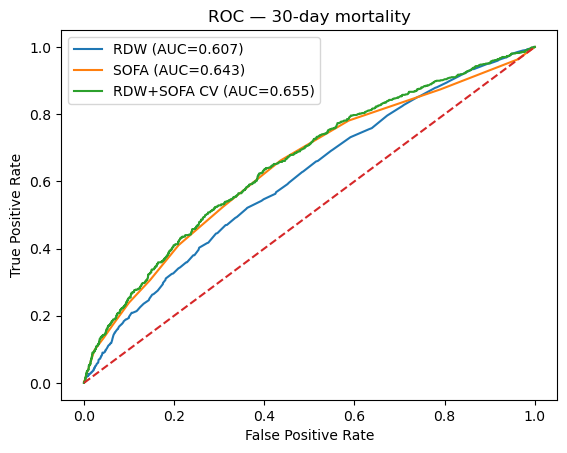

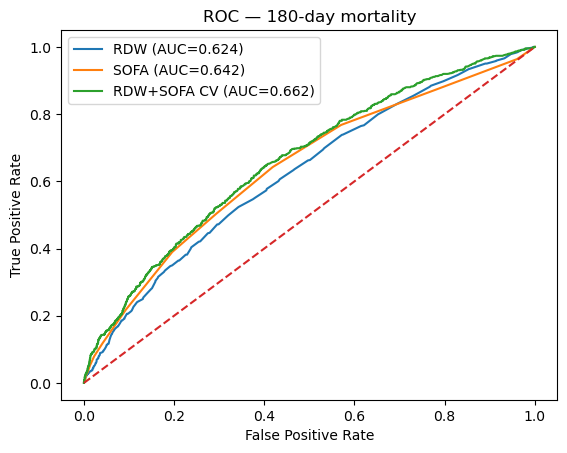

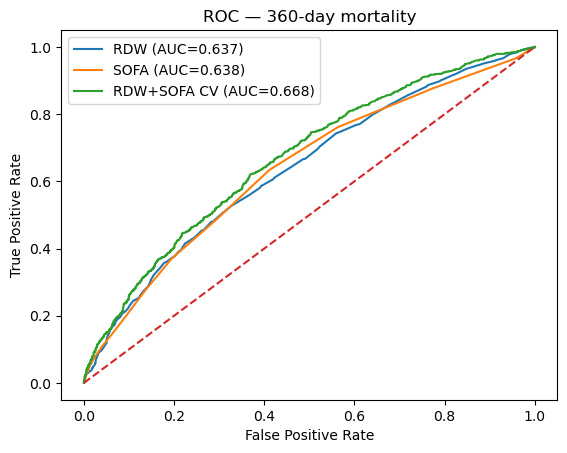

,H,N_used,events,AUC_RDW,CI_RDW_low,CI_RDW_high,AUC_SOFA,CI_SOFA_low,CI_SOFA_high,AUC_RDW+SOFA_CV,CI_combo_low,CI_combo_high
0,30,3030,666,0.607,0.583,0.630,0.643,0.619,0.668,0.655,0.631,0.678
1,180,3030,909,0.624,0.603,0.644,0.642,0.621,0.663,0.662,0.642,0.683
2,360,3030,1018,0.637,0.616,0.658,0.638,0.617,0.658,0.668,0.647,0.688


In [16]:
# --- Ρύθμιση predictors ---

rdw_col = "RDW - Median"   # ή "RDW - Mean"

assert rdw_col in df.columns
assert "sofa" in df.columns

# ------------------------------------------------------------
# Bootstrap CI για AUC (stratified bootstrap για σταθερότητα)
# ------------------------------------------------------------
def auc_bootstrap_ci(y_true, y_score, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    idx0 = np.where(y_true == 0)[0]
    idx1 = np.where(y_true == 1)[0]

    aucs = []
    for _ in range(n_boot):
        b0 = rng.choice(idx0, size=len(idx0), replace=True)
        b1 = rng.choice(idx1, size=len(idx1), replace=True)
        b = np.concatenate([b0, b1])
        aucs.append(roc_auc_score(y_true[b], y_score[b]))

    aucs = np.array(aucs)
    lo, hi = np.percentile(aucs, [2.5, 97.5])
    return float(lo), float(hi)

# ------------------------------------------------------------
# AUC computation per horizon
# ------------------------------------------------------------
def compute_auc_for_horizon(df, H, rdw_col, n_boot=2000, seed=42, make_plots=False):
    y_col = f"mort_{H}d"

    # Κοινό δείγμα για δίκαιη σύγκριση RDW vs SOFA vs RDW+SOFA:
    sub = df[[y_col, rdw_col, "sofa"]].dropna().copy()

    y = sub[y_col].astype(int).values
    rdw_score = sub[rdw_col].astype(float).values
    sofa_score = sub["sofa"].astype(float).values

    # RDW-only AUC
    auc_rdw = roc_auc_score(y, rdw_score)
    ci_rdw = auc_bootstrap_ci(y, rdw_score, n_boot=n_boot, seed=seed)

    # SOFA-only AUC
    auc_sofa = roc_auc_score(y, sofa_score)
    ci_sofa = auc_bootstrap_ci(y, sofa_score, n_boot=n_boot, seed=seed+1)

    # RDW + SOFA (LogReg) με CV προβλέψεις (out-of-fold probabilities)
    X = sub[[rdw_col, "sofa"]].values
    lr = LogisticRegression(max_iter=2000, solver="lbfgs")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    p_cv = cross_val_predict(lr, X, y, cv=cv, method="predict_proba")[:, 1]

    auc_combo = roc_auc_score(y, p_cv)
    ci_combo = auc_bootstrap_ci(y, p_cv, n_boot=n_boot, seed=seed+2)

    out = {
        "H": H,
        "N_used": len(sub),
        "events": int(y.sum()),
        "AUC_RDW": auc_rdw, "CI_RDW_low": ci_rdw[0], "CI_RDW_high": ci_rdw[1],
        "AUC_SOFA": auc_sofa, "CI_SOFA_low": ci_sofa[0], "CI_SOFA_high": ci_sofa[1],
        "AUC_RDW+SOFA_CV": auc_combo, "CI_combo_low": ci_combo[0], "CI_combo_high": ci_combo[1],
    }

    # ROC curves
    if make_plots:
        import matplotlib.pyplot as plt

        def plot_roc(y_true, score, label):
            fpr, tpr, _ = roc_curve(y_true, score)
            plt.plot(fpr, tpr, label=label)

        plt.figure()
        plot_roc(y, rdw_score,  f"RDW (AUC={auc_rdw:.3f})")
        plot_roc(y, sofa_score, f"SOFA (AUC={auc_sofa:.3f})")
        plot_roc(y, p_cv,       f"RDW+SOFA CV (AUC={auc_combo:.3f})")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.title(f"ROC — {H}-day mortality")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    return out

# Run for 30/180/360
rows = []
for H in [30, 180, 360]:
    rows.append(compute_auc_for_horizon(df, H, rdw_col, n_boot=2000, seed=42, make_plots=True))

auc_df = pd.DataFrame(rows)

# πιο ωραίο formatting
for c in [c for c in auc_df.columns if c.startswith("AUC_") or c.startswith("CI_")]:
    auc_df[c] = auc_df[c].astype(float).round(3)

auc_df


# DeLong test

In [19]:
# -----------------------------
# DeLong implementation
# -----------------------------
def _compute_midrank(x):
    """Computes midranks for a 1D array x."""
    x = np.asarray(x)
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        # ranks are 1..N
        mid = 0.5 * (i + j - 1) + 1
        T[i:j] = mid
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2

def _fast_delong(predictions_sorted_transposed, label_1_count):
    """
    Fast DeLong for AUC covariance.
    predictions_sorted_transposed: shape (n_classifiers, n_examples) with examples sorted: positives first.
    """
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m

    pos = predictions_sorted_transposed[:, :m]
    neg = predictions_sorted_transposed[:, m:]

    k = predictions_sorted_transposed.shape[0]
    tx = np.zeros((k, m), dtype=float)
    ty = np.zeros((k, n), dtype=float)
    tz = np.zeros((k, m + n), dtype=float)

    for r in range(k):
        tz[r, :] = _compute_midrank(predictions_sorted_transposed[r, :])
        tx[r, :] = _compute_midrank(pos[r, :])
        ty[r, :] = _compute_midrank(neg[r, :])

    aucs = (tz[:, :m].sum(axis=1) - m * (m + 1) / 2.0) / (m * n)

    v01 = (tz[:, :m] - tx) / n
    v10 = 1.0 - (tz[:, m:] - ty) / m

    sx = np.cov(v01)
    sy = np.cov(v10)
    delong_cov = sx / m + sy / n
    return aucs, delong_cov

def delong_roc_test(y_true, pred1, pred2):
    """
    Returns: auc1, auc2, auc_diff, p_value (two-sided), z
    """
    y_true = np.asarray(y_true).astype(int)
    pred1 = np.asarray(pred1).astype(float)
    pred2 = np.asarray(pred2).astype(float)

    # sort so that positives (1) are first
    order = np.argsort(y_true)[::-1]
    y_sorted = y_true[order]
    m = int(y_sorted.sum())
    if m == 0 or m == len(y_sorted):
        raise ValueError("Need both positive and negative samples for DeLong test.")

    preds = np.vstack([pred1, pred2])[:, order]
    aucs, cov = _fast_delong(preds, m)

    auc1, auc2 = float(aucs[0]), float(aucs[1])
    diff = auc1 - auc2
    var_diff = float(cov[0, 0] + cov[1, 1] - 2 * cov[0, 1])

    if var_diff <= 0:
        # numerical edge case
        z = np.nan
        p = np.nan
    else:
        z = diff / np.sqrt(var_diff)
        if norm is not None:
            p = 2 * norm.sf(abs(z))
        else:
            # fallback (approx) if scipy not available
            from math import erf, sqrt
            p = 2 * (1 - 0.5 * (1 + erf(abs(z) / sqrt(2))))

    return auc1, auc2, diff, float(p), float(z)

# -----------------------------
# Run DeLong for each horizon
# -----------------------------
rdw_col = "RDW - Median"   # άλλαξέ το αν χρησιμοποιείς Mean
seed = 42

def get_scores_for_horizon(df, H, rdw_col, seed=42):
    y_col = f"mort_{H}d"
    sub = df[[y_col, rdw_col, "sofa"]].dropna().copy()

    y = sub[y_col].astype(int).values
    rdw_score = sub[rdw_col].astype(float).values
    sofa_score = sub["sofa"].astype(float).values

    # RDW+SOFA score via out-of-fold probabilities (5-fold CV)
    X = sub[[rdw_col, "sofa"]].values
    lr = LogisticRegression(max_iter=2000, solver="lbfgs")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    p_cv = cross_val_predict(lr, X, y, cv=cv, method="predict_proba")[:, 1]

    return sub, y, rdw_score, sofa_score, p_cv

rows = []
for H in [30, 180, 360]:
    sub, y, rdw_score, sofa_score, combo_score = get_scores_for_horizon(df, H, rdw_col, seed=seed)

    # DeLong comparisons
    a1, a2, d, p, z = delong_roc_test(y, combo_score, sofa_score)  # combo vs sofa
    rows.append({"H": H, "comparison": "RDW+SOFA (CV) vs SOFA", "AUC_1": a1, "AUC_2": a2, "AUC_diff": d, "p_value": p, "z": z, "N": len(sub), "events": int(y.sum())})

    a1, a2, d, p, z = delong_roc_test(y, sofa_score, rdw_score)   # sofa vs rdw
    rows.append({"H": H, "comparison": "SOFA vs RDW", "AUC_1": a1, "AUC_2": a2, "AUC_diff": d, "p_value": p, "z": z, "N": len(sub), "events": int(y.sum())})

    a1, a2, d, p, z = delong_roc_test(y, combo_score, rdw_score)  # combo vs rdw
    rows.append({"H": H, "comparison": "RDW+SOFA (CV) vs RDW", "AUC_1": a1, "AUC_2": a2, "AUC_diff": d, "p_value": p, "z": z, "N": len(sub), "events": int(y.sum())})

delong_df = pd.DataFrame(rows)
delong_df[["AUC_1","AUC_2","AUC_diff"]] = delong_df[["AUC_1","AUC_2","AUC_diff"]].round(4)
delong_df["p_value"] = delong_df["p_value"].map(lambda x: f"{x:.3g}")
delong_df


,H,comparison,AUC_1,AUC_2,AUC_diff,p_value,z,N,events
0,30,RDW+SOFA (CV) vs SOFA,0.6553,0.6431,0.0122,0.0204,2.318384,3030,666
1,30,SOFA vs RDW,0.6431,0.6074,0.0358,0.0176,2.373979,3030,666
2,30,RDW+SOFA (CV) vs RDW,0.6553,0.6074,0.0480,1.81e-05,4.287488,3030,666
3,180,RDW+SOFA (CV) vs SOFA,0.6620,0.6415,0.0205,0.000499,3.481302,3030,909
4,180,SOFA vs RDW,0.6415,0.6241,0.0175,0.199,1.283168,3030,909
5,180,RDW+SOFA (CV) vs RDW,0.6620,0.6241,0.0380,2.6e-05,4.205977,3030,909
6,360,RDW+SOFA (CV) vs SOFA,0.6680,0.6375,0.0305,6.57e-06,4.507244,3030,1018
7,360,SOFA vs RDW,0.6375,0.6370,0.0005,0.969,0.038253,3030,1018
8,360,RDW+SOFA (CV) vs RDW,0.6680,0.6370,0.0310,6.36e-05,3.999156,3030,1018


# Youden index

In [21]:
from sklearn.metrics import roc_curve

def youden_cutoff(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    # drop inf threshold if exists
    mask = np.isfinite(thr)
    fpr, tpr, thr = fpr[mask], tpr[mask], thr[mask]

    j = tpr - fpr
    ix = int(np.argmax(j))
    return {
        "cutoff": float(thr[ix]),
        "sensitivity": float(tpr[ix]),
        "specificity": float(1 - fpr[ix]),
        "youden_J": float(j[ix])
    }
rows = []
for H in [30, 180, 360]:
    sub, y, rdw_score, sofa_score, combo_score = get_scores_for_horizon(df, H, rdw_col, seed=seed)

    r = youden_cutoff(y, rdw_score)
    rows.append({"H": H, "score": "RDW", **r})

    r = youden_cutoff(y, sofa_score)
    rows.append({"H": H, "score": "SOFA", **r})

    r = youden_cutoff(y, combo_score)
    rows.append({"H": H, "score": "RDW+SOFA (CV prob)", **r})

youden_df = pd.DataFrame(rows)
youden_df[["cutoff","sensitivity","specificity","youden_J"]] = youden_df[["cutoff","sensitivity","specificity","youden_J"]].round(3)
youden_df


,H,score,cutoff,sensitivity,specificity,youden_J
0,30,RDW,14.350,0.521,0.638,0.159
1,30,SOFA,4.000,0.662,0.564,0.226
2,30,RDW+SOFA (CV prob),0.199,0.635,0.601,0.236
3,180,RDW,14.400,0.521,0.660,0.181
4,180,SOFA,4.000,0.642,0.581,0.224
5,180,RDW+SOFA (CV prob),0.268,0.651,0.594,0.245
6,360,RDW,14.400,0.528,0.672,0.200
7,360,SOFA,4.000,0.634,0.589,0.223
8,360,RDW+SOFA (CV prob),0.312,0.620,0.631,0.251
